In [10]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from pymoo.problems import get_problem
from pymoo.indicators.gd import GD
from tqdm import tqdm
from joblib import Parallel, delayed
import threading
np.random.seed(42)


In [11]:
class GeneticAlgorithm():
    def __init__(self, POPULATION_SIZE, VARBOUND, MUTATION_RATE, CROSSOVER_RATE) -> None:
        self.POPULATION_SIZE  = POPULATION_SIZE
        self.VARBOUND         = VARBOUND
        self.MUTATION_RATE    = MUTATION_RATE
        self.CROSSOVER_RATE   = CROSSOVER_RATE

    def initial_populations(self):
        population_ = []
        for _ in range(self.POPULATION_SIZE):
            population_.append(np.array([np.random.uniform(low, high) for low, high in self.VARBOUND]))
        return np.array(population_)

    def crossover(self, gene1_, gene2_):
        assert len(gene1_) == len(gene2_), "genes genes must have the same length"
        crossover_point = np.random.randint(1, len(gene1_))
        if np.random.rand() < self.CROSSOVER_RATE:
            offspring1 = gene1_[:crossover_point].tolist() + gene2_[crossover_point:].tolist()
            offspring2 = gene2_[:crossover_point].tolist() + gene1_[crossover_point:].tolist()
            return np.array(offspring1), np.array(offspring2)
        return gene1_, gene2_

    def search_methods(self, gene1, gene2):
        gene1, gene2 = self.crossover(gene1_=gene1, gene2_=gene2)
        gene1 = self.polynomial_mutation(gene=gene1)
        gene2 = self.polynomial_mutation(gene=gene2)
        return gene1, gene2

    def polynomial_mutation(self, gene, distribution_index=20):
        mutated_gene = gene.copy()
        for i in range(len(gene)):
            if np.random.rand() < self.MUTATION_RATE:
                u = np.random.rand()
                delta = 0.0
                if u < 0.5:
                    delta = (2.0 * u) ** (1.0 / (distribution_index + 1)) - 1.0
                else:
                    delta = 1.0 - (2.0 * (1.0 - u)) ** (1.0 / (distribution_index + 1))
                mutated_gene[i] += delta
                # Ensure the mutated value stays within the specified bounds
                mutated_gene[i] = np.clip(mutated_gene[i], self.VARBOUND[i][0], self.VARBOUND[i][1])
        return mutated_gene

In [12]:
class MOP(GeneticAlgorithm):
    def __init__(self, POPULATION_SIZE, VARBOUND, MUTATION_RATE, CROSSOVER_RATE,  PROBLEM, OBJECTIVES_NUMBER) -> None:
        super().__init__(POPULATION_SIZE, VARBOUND, MUTATION_RATE, CROSSOVER_RATE)
        self.PROBLEM           = PROBLEM
        self.OBJECTIVES_NUMBER = OBJECTIVES_NUMBER

    def problem_output(self, individual):
        out = {"F":[0], "G":[0]}
        self.PROBLEM._evaluate(np.array([individual]), out)
        return np.array(out["F"][0])

    def weighted_sum(self, individual, weights):
        return self.problem_output(individual) @ weights

    def PBI(self, individual, weights):
        Z = np.min(self.PROBLEM._calc_pareto_front(), axis=0)
        F_X = self.problem_output(individual)
        d1 = np.linalg.norm((Z-F_X)@weights) / np.linalg.norm(weights)
        d2 = np.linalg.norm(F_X - (Z + d1*weights))
        return 10*d1 + d2

    def IGD_calc(self, population):
      f_ep = []
      for i in population:
        f_ep.append(op.problem_output(i))

      pareto = self.PROBLEM._calc_pareto_front()
      ind = GD(pareto)
      print("GD", ind(np.array(f_ep)))

    def refrence_points(self):
        ...

In [13]:
class MOEAD(MOP):
    def __init__(self, POPULATION_SIZE, VARBOUND, PROBLEM, OBJECTIVES_NUMBER, MUTATION_RATE, CROSSOVER_RATE, GENE_MAX, NEIGHTBORS_NUMBER) -> None:
        super().__init__(POPULATION_SIZE, VARBOUND, MUTATION_RATE, CROSSOVER_RATE,  PROBLEM, OBJECTIVES_NUMBER)
        self.GENE_MAX = GENE_MAX
        self.NEIGHTBORS_NUMBER = NEIGHTBORS_NUMBER


    def spa(self, population, weights):
      spa = np.zeros((self.POPULATION_SIZE,))
      temp = np.zeros((self.NEIGHTBORS_NUMBER,))
      for k in range(self.POPULATION_SIZE):
        for i in range(self.NEIGHTBORS_NUMBER):
          sum = 0
          for j in range(self.OBJECTIVES_NUMBER):
            sum += (self.problem_output(population[k])[j] - self.problem_output(population[i])[j])**2
          temp[i] = np.sqrt(sum)
        spa[k] = np.min(temp)
      weights[np.argmin(spa)] = np.mean(weights[np.argsort(spa)[-2:]])
      return weights

    def algorithm1(self, population, weights):
      for _ in tqdm(range(self.GENE_MAX)):
        weights = self.spa(population, weights)
      return weights


    def moead(self):
        EP = []
        population = self.initial_populations()
        EP = population.copy().tolist()
        weights = np.random.rand(self.POPULATION_SIZE, self.OBJECTIVES_NUMBER)

        # weights = self.algorithm1(population, weights)
        # nbs = NearestNeighbors(n_neighbors=self.NEIGHTBORS_NUMBER)
        # nbs.fit(weights)
        # _ , B= nbs.kneighbors(weights)

        for t in tqdm(range(self.GENE_MAX)):
            weights = self.spa(population, weights)
            self.NEIGHTBORS_NUMBER = int((1 - .5*t/self.GENE_MAX) * self.NEIGHTBORS_NUMBER)
            self.NEIGHTBORS_NUMBER = self.NEIGHTBORS_NUMBER if self.NEIGHTBORS_NUMBER > 1 else 2
            nbs = NearestNeighbors(n_neighbors=self.NEIGHTBORS_NUMBER)
            nbs.fit(weights)
            _ , B= nbs.kneighbors(weights)
            for i in range(self.POPULATION_SIZE):

                k, l = np.random.choice(B[i], 2, replace=False)
                y1, y2 = self.search_methods(population[k], population[l])
                for j in B[i]:
                    if self.PBI(y1, weights[j]) < self.PBI(population[j], weights[j]):
                        population[j] = y1
                        EP.append(y1)
                    if self.PBI(y2, weights[j]) < self.PBI(population[j], weights[j]):
                        population[j] = y2
                        EP.append(y2)
                EP = self.filter_dominated(EP)

        self.plot(EP)
        self.plot(population)
        self.IGD_calc(population)
        self.IGD_calc(EP)
        return population, EP

    def is_dominated(self, x, y):
      """
      Check if solution x is dominated by solution y.
      """
      x = self.problem_output(x)
      y = self.problem_output(y)
      return all(x[i] <= y[i] for i in range(len(x)))

    def filter_dominated(self, population):
      """
      Filter out dominated individuals from the population.
      """
      if len(population) == 1: return population
      non_dominated = []
      for i, indv in enumerate(population):
          dominated = False
          for j, other_indv in enumerate(population):
              if i != j and self.is_dominated(other_indv, indv):
                  dominated = True
                  break
          if not dominated:
              non_dominated.append(indv)
      return non_dominated

    def plot(self, P):
        for individ in P:
            f = self.problem_output(individ)
            plt.scatter(f[0], f[1], c='r',zorder=1)
        plt.show()
        print("")



START ROUND:0 _________________________________________________________________________________
zdt1: 

100%|██████████| 100/100 [07:01<00:00,  4.21s/it]


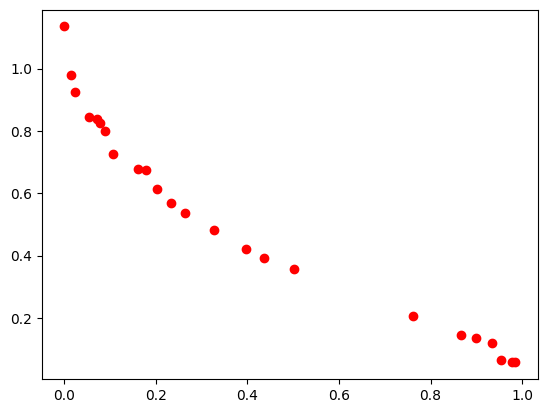

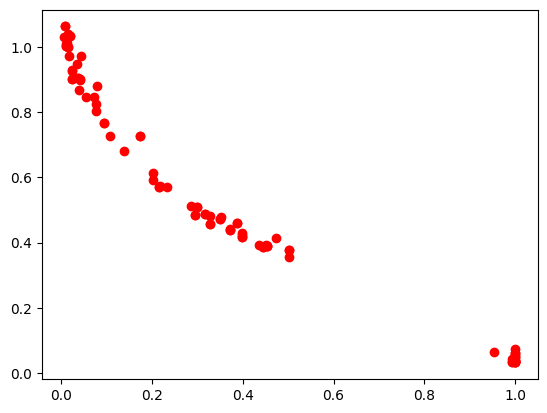


GD 0.0392958999126504
GD 0.0496796244594561
zdt2: 

100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


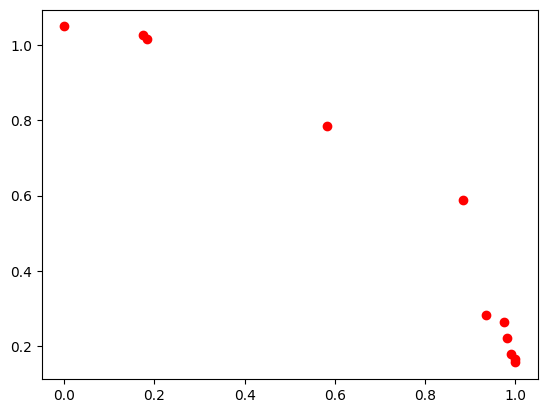

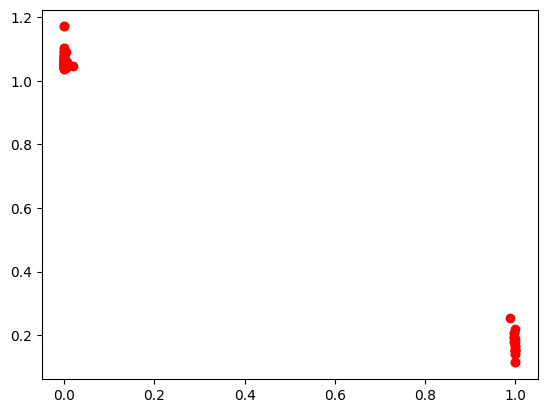


GD 0.06535648041965597
GD 0.08346063000798998
zdt3: 

100%|██████████| 100/100 [02:36<00:00,  1.56s/it]


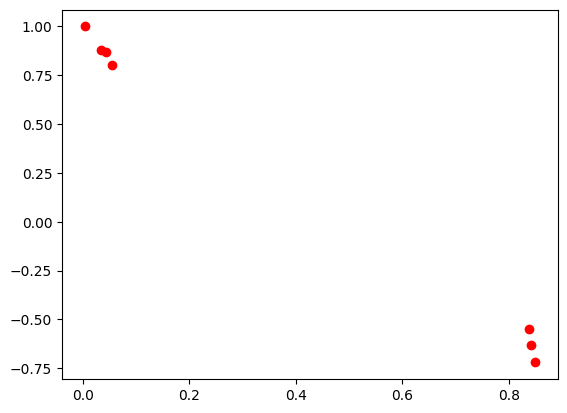

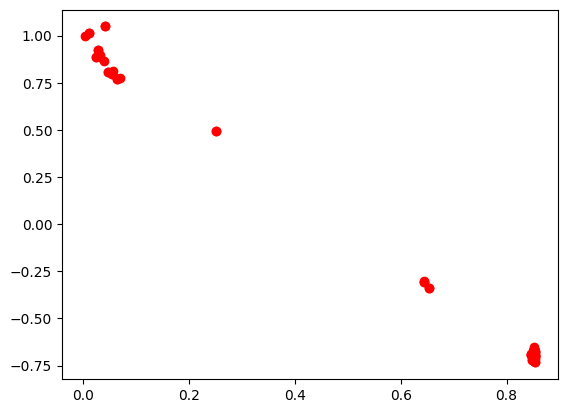


GD 0.0171146256783984
GD 0.016426763909241117
zdt4: 

100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


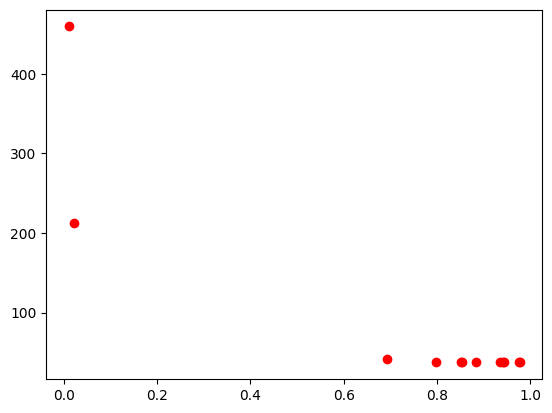

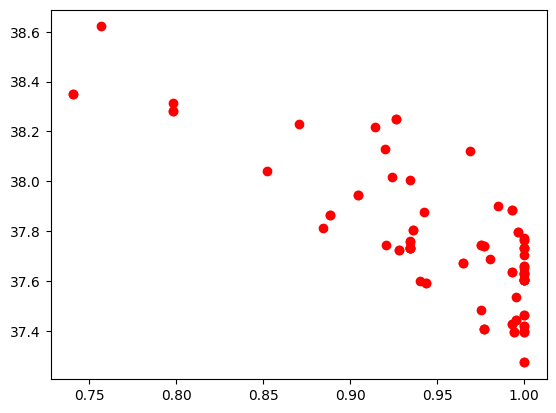


GD 36.75229120730027
GD 86.81747588807924
zdt6: 

100%|██████████| 100/100 [09:41<00:00,  5.81s/it]


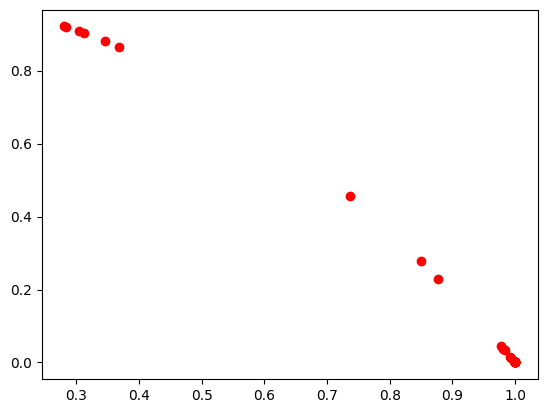

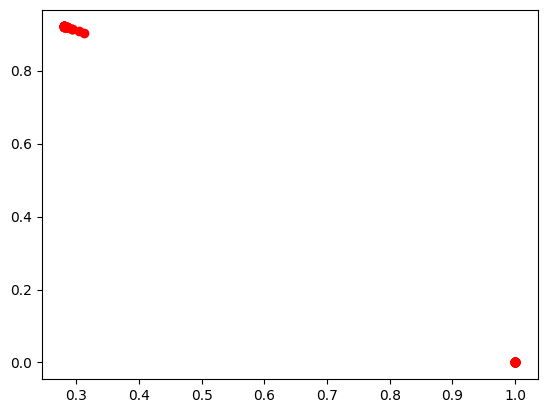


GD 0.0006272900641925152
GD 0.001417980242288145
END ROUND:0 _________________________________________________________________________________
START ROUND:1 _________________________________________________________________________________
zdt1: 

100%|██████████| 100/100 [08:52<00:00,  5.32s/it]


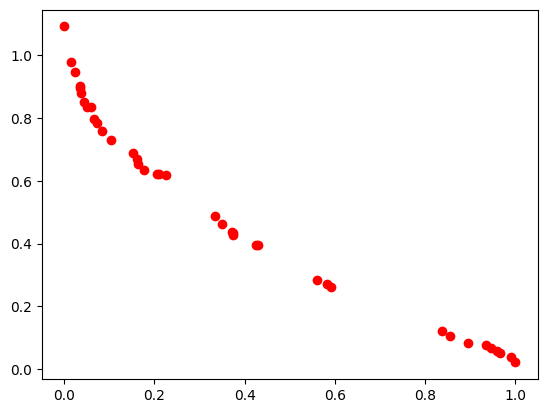

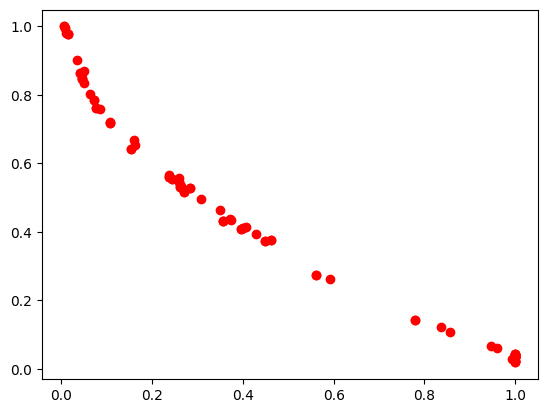


GD 0.02861737574292503
GD 0.035115937252211786
zdt2: 

100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


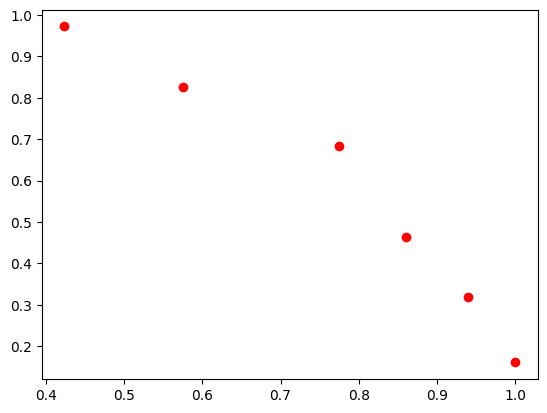

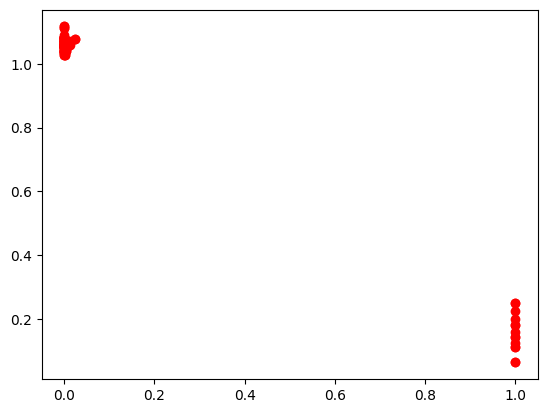


GD 0.06362527931886232
GD 0.11172478318978313
zdt3: 

100%|██████████| 100/100 [04:18<00:00,  2.58s/it]


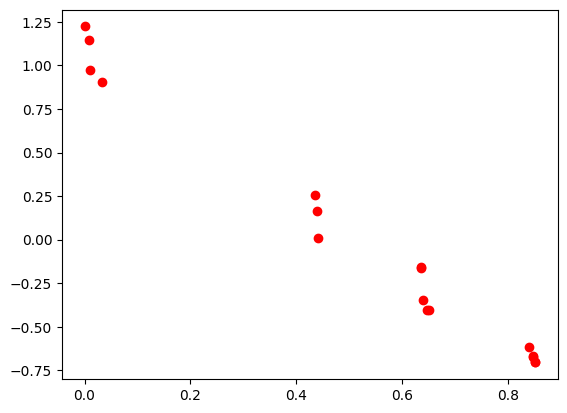

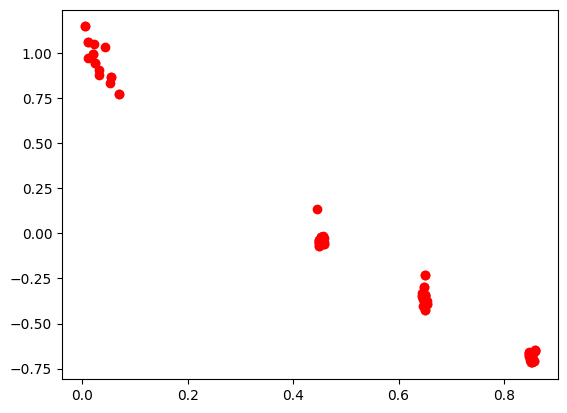


GD 0.022839875244764732
GD 0.03598561638644751
zdt4: 

100%|██████████| 100/100 [05:41<00:00,  3.41s/it]


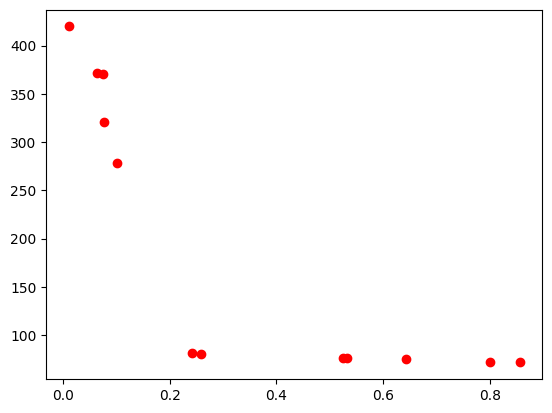

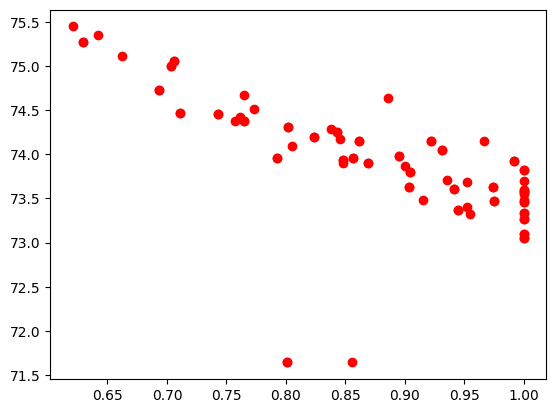


GD 72.93874180871657
GD 190.24896420718804
zdt6: 

100%|██████████| 100/100 [09:05<00:00,  5.46s/it]


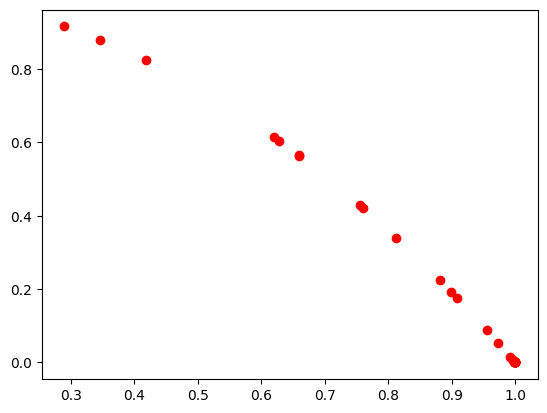

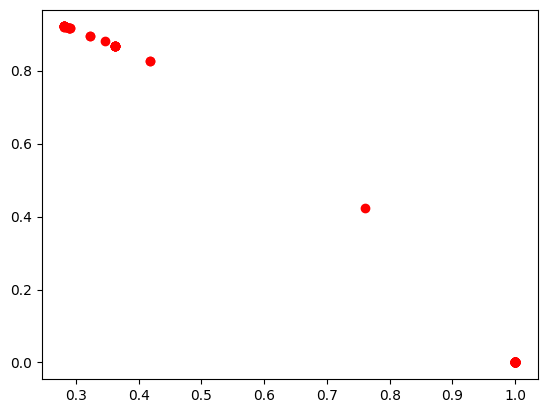


GD 0.0006232632989606854
GD 0.0016934688353812248
END ROUND:1 _________________________________________________________________________________
START ROUND:2 _________________________________________________________________________________
zdt1: 

100%|██████████| 100/100 [06:29<00:00,  3.89s/it]


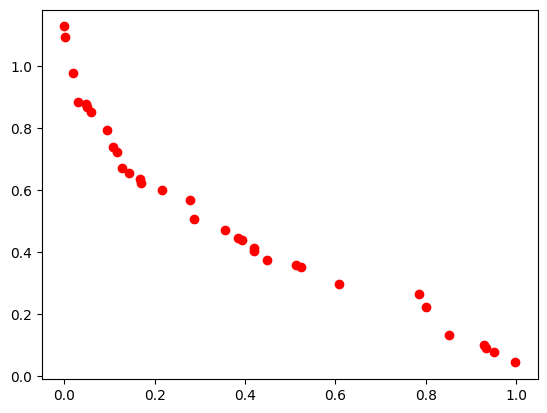

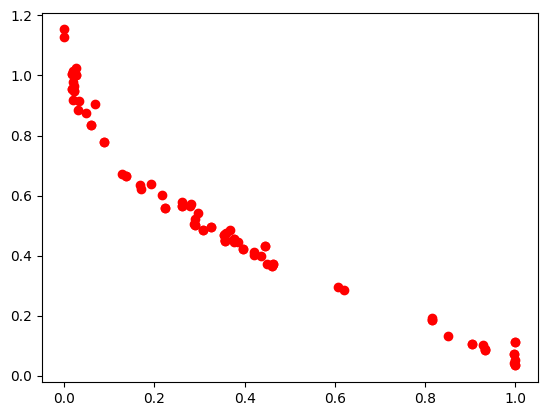


GD 0.04694334486022971
GD 0.050620780798383905
zdt2: 

100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


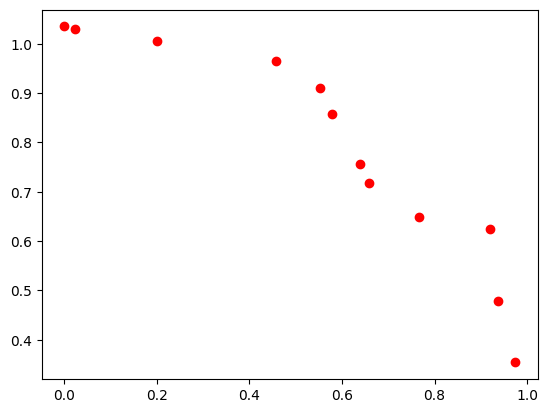

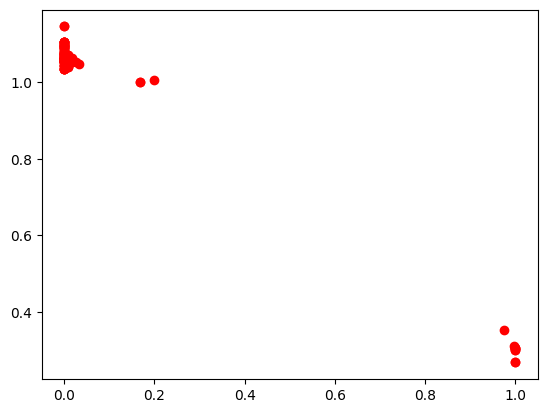


GD 0.07588875484679143
GD 0.11955663736945392
zdt3: 

100%|██████████| 100/100 [02:42<00:00,  1.63s/it]


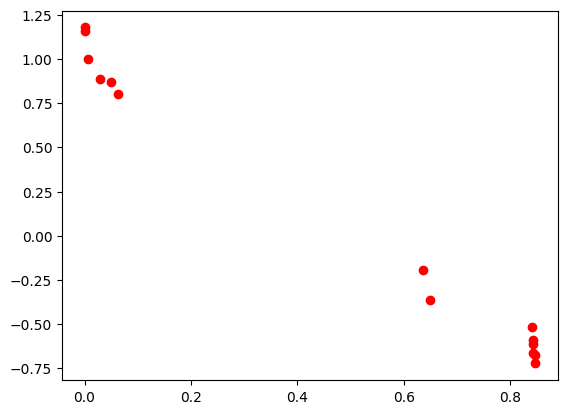

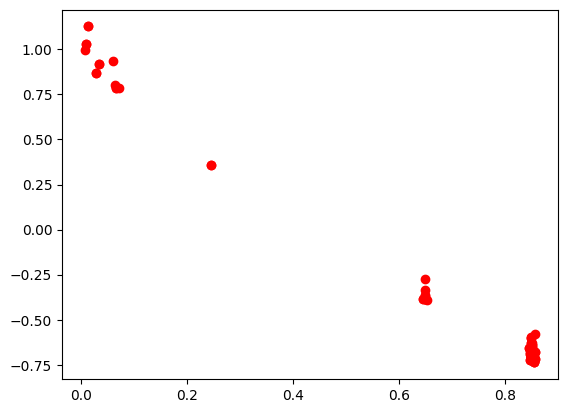


GD 0.01853392384654063
GD 0.038075079145480396
zdt4: 

100%|██████████| 100/100 [04:08<00:00,  2.48s/it]


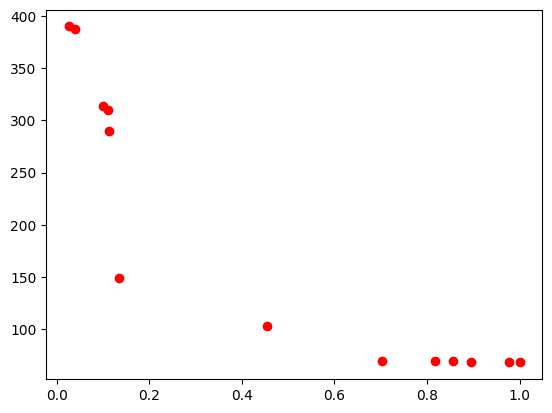

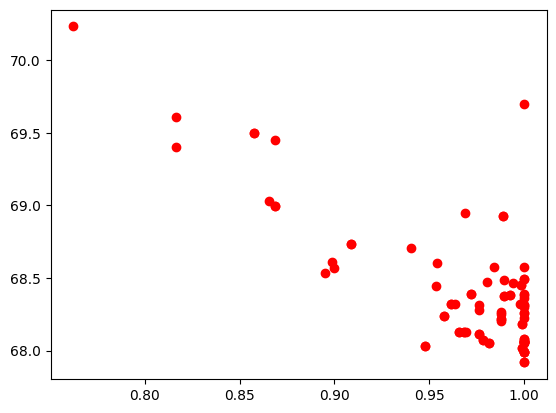


GD 67.41627954762151
GD 180.2413473051489
zdt6: 

100%|██████████| 100/100 [07:34<00:00,  4.55s/it]


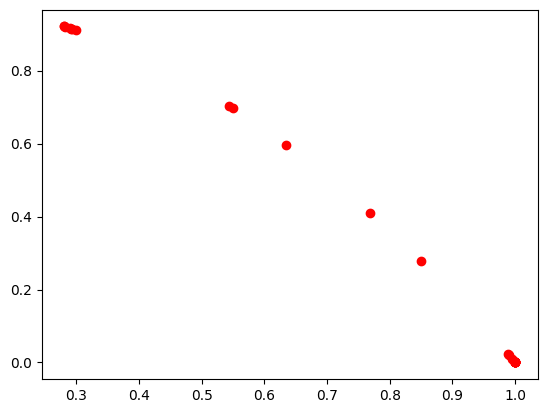

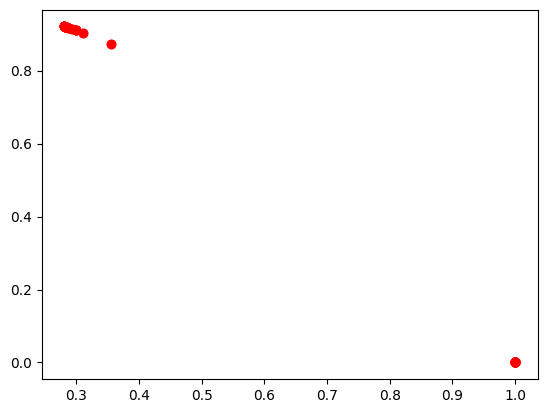


GD 0.0006591595033956979
GD 0.0020037536102830325
END ROUND:2 _________________________________________________________________________________
START ROUND:3 _________________________________________________________________________________
zdt1: 

  2%|▏         | 2/100 [00:04<03:33,  2.18s/it]


KeyboardInterrupt: 

In [15]:
problem_name = [
    'zdt1', 'zdt2', 'zdt3', 'zdt4', 'zdt6',
]
var_bounds = [
    [[0,1]]*30, [[0,1]]*30, [[0,1]]*30, [[0,1]]+[[-10,10]]*9, [[0,1]]*10
]
objective_num = [
    2, 2, 2, 2, 2
]
for _ in range(5):
  print(f"START ROUND:{_} _________________________________________________________________________________")
  for index in range(5):
    print(problem_name[index], end=": ")
    op = MOEAD(POPULATION_SIZE = 91,
          VARBOUND =np.array(var_bounds[index]),
          PROBLEM = get_problem(problem_name[index]),
          OBJECTIVES_NUMBER = 2,
          MUTATION_RATE =  .5,
          CROSSOVER_RATE = .5,
          GENE_MAX = 100,
          NEIGHTBORS_NUMBER = 15)
    pop, ep = op.moead()
  print(f"END ROUND:{_} _________________________________________________________________________________")